# Linguistic gender biases in Wikipedia

## Table of contents

1. [Introduction](#Introduction)
2. [Data preprocesing and extraction](#Data-preprocessing-and-extraction)
3. [Imports](#Imports) 
    1. [Libraries](#Libraries)
    2. [Dictionaries](#Dictionaries)
4. [Gender exploration](#Gender-exploration)
5. [Data exploration](#Data-exploration)
    1. [Gender distribution](#Gender-distribution)
    2. [Occupation distribution](#Occupation-distribution)
    3. [Gender by occupation](#Gender-by-occupation)
    4. [Distribution of the overview's length](#Distribution-of-the-overview's-length)
    5. [Distribution of the percentage of adjectives in an overview](#Distribution-of-the-percentage-of-adjectives-in-an-overview)
    6. [Number of adjectives in an overview](#Number-of-adjectives-in-an-overview)
7. [Adjectives analysis](#Adjectives-analysis)
    1. [Associate subjectivity level and strength to each adjective](#Associate-subjectivity-level-and-strength-to-each-adjective)
    2. [Word cloud for the most common adjectives](#Word-cloud-for-the-most-common-adjectives)
    3. [Usage of strongly subjective adjectives depending on the gender](#Usage-of-strongly-subjective-adjectives-depending-on-the-gender)
8. [Model](#Model)
9. [Next steps](#Next-steps)

## Introduction

Wikipedia has become a very large source of information. By November 2019, the number of entries in the English Wikipedia was above 5M [[1]](https://en.wikipedia.org/wiki/Wikipedia:Statistics#Page_views) and it was increasing everyday at a rate of 500 entries in averge. 

In previous studies Wagner et al [[2]](https://arxiv.org/abs/1501.06307) showed how gender biases manifest in Wikipedia in the way women and men are portrayed. In a different study, Graells-Garrido et al [[3]](https://labtomarket.files.wordpress.com/2018/01/wiki_gender_bias.pdf) showed that women biographies are more likely to contain sex-related content. Along with these studies, several others have studied topic-related biases in the way women are portrayed but we can also take a look from the linguistic perspective. 

Linguistic biases is defined as a systematic asymmetry in word choice that reflects the social-category cognitions that are applied to the described group or individual(s) [[4]](https://oxfordre.com/communication/communication/view/10.1093/acrefore/9780190228613.001.0001/acrefore-9780190228613-e-439). We want to analyze how men and women are protrayed and more specifically, the adjectives used to describe them with the aim to spot possible biases from a linguistic perspective. To do so, we will use the overview of the biographies in the English Wikipedia together with other characteristics of the people we are analysing.

Initially we will start by exploring the dataset, i.e. ratio of male and female entries, presence of other genders, etc. Later, we will explore the language used on the overviews by focusing on the adjectives. We restrict the analysis to adjectives given the level of abstraction they provide [[5]](https://www.aaai.org/ocs/index.php/ICWSM/ICWSM15/paper/download/10539/10513). This analysis will be conducted by first extracting the most frequent adjectives from all the biographies used. With them we will build a vocabulary and use it to create a representation of each character based on the adjectives in our vocabulary that appear in its biography. 

Once we have a vectorial representation of each person, we will create a model using logistic regression that will try to predict if a biography belongs to a male or female. If this task becomes feasible, it means there is a pattern in the usage of language that allows us to make a distinction between genders, highlighting the presence of a bias. Will our model succeed in its tasks? Continue with us to discover our results! 

[[1] Wikipedia Statistics](https://en.wikipedia.org/wiki/Wikipedia:Statistics#Page_views)

[[2] It's a Man's Wikipedia? Assessing Gender Inequality in an Online Encyclopedia](https://arxiv.org/abs/1501.06307)

[[3] First Women, Second Sex: Gender Bias in Wikipedia](https://labtomarket.files.wordpress.com/2018/01/wiki_gender_bias.pdf)

[[4] Oxford Research Encyclopedia](https://oxfordre.com/communication/communication/view/10.1093/acrefore/9780190228613.001.0001/acrefore-9780190228613-e-439)

[[5] Linguistic Bias in Collaboratively Produced Biographies: Crowdsourcing Social Stereotypes?](https://www.aaai.org/ocs/index.php/ICWSM/ICWSM15/paper/download/10539/10513)

## Data preprocessing and extraction

As stated before, we are only interested in analysing the biographies of the English Wikipedia, so we need to filter them. More precisely, we will use the overviews. In order to do that, we followed these steps:

1. We use the [Wikidata Human Gender Indicators (WHGI)](#http://whgi.wmflabs.org) dataset, which contains all the biography articles in all Wikipedias and it is updated weekly. We use this dataset because it is more updated than the Wikidata one in cluster (dated from 2017). From this dataset (version from November the 4th, 2019 version), we get all the biographies that are in the English Wikipedia and that have a gender. For each entry, we get the Q-id (unique identifier in Wikidata), gender and occupation. Code in [here](createDataset/1_extract_qid_wikidata.py).


2. Then, we need to link the previous information with the Wikipedia article. For that, we use the Wikidata dataset found in the cluster. First, we filter the entries that we obtained in the previous step and obtain the name of the entry in the English Wikipedia. Code in [here](createDataset/2_extract_people_wikidata.py).


3. Next, we have to obtain the biographies from Wikipedia dataset. To do that, we simply join the English Wikipedia dataset (also found in the cluster) with the one obtained in the previous step by the Wikipedia title, which is unique. Code in [here](createDataset/3_filter_people_enwiki.py).


4. Following, we need to extract and clear the overview of the wikipedia text. First, we find the end of the overview (which usually starts either with `==` or `[[Category:` ). Then we clear the references, comments from the editors, quotes and text inside curly brackets. Code in [here](createDataset/4_extract_overview_enwiki.py).


5. Finally, as it will be shown later in the analysis, we filter the database according to gender of the people. We keep only the male and the female as the other genders represent less than 1% of the whole dataset. Code in [here](createDataset/5_filter_female_male.py). 

The final dataset contains 1,383,430 entries and it has the following schema:
```
root
 |-- gender: string (nullable = true)
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- wiki-title: string (nullable = true)
```

The **gender** is represented by the its Wikidata code, the **ID** is the unique code from Wikidata, the **name** is the name of the person (not necessarily unique), the **occupation** is a list of codes from Wikidata corresponding to the occupations of one person, the **overview** is the clean introduction of Wikipedia and the **wiki-title** is the unique name from the English Wikipedia.

## Imports 

### Libraries

In [1]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score

import os
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import seaborn as sns

from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.types import IntegerType

# set random seed
np.random.seed(8)

# set font size for plots
matplotlib.rcParams.update({'font.size': 11})

import warnings
warnings.filterwarnings('ignore')

### Dictionaries

In this section, we load the dictionaries used to tranform the codes in the dataset to the corresponding name (dict_genders and dict_occupations). We also load a dictionary to group the occupations by field and the subjectivity lexicon used to analyze the adjectives.

In [2]:
# Open Gender dictionary
with open('../data/dict_genders.json') as json_file:
    line = json_file.readline()
    dict_genders = json.loads(line)
    
# Open occupations dictionary
dict_occupations = {}
with open('../data/dict_occupations.json') as json_file:
    content = json_file.readlines()
    for line in content:
        occ = json.loads(line)
        dict_occupations.update(occ)
        
# Open occupations categories dictionary
with open('../data/dict_categories_occupations.json') as json_file:
    line = json_file.readline()
    dict_cat_occ = json.loads(line)

# Open subjectivity lexicon
subjectivity_dictionary = {}
with open('../data/subjectivity_dictionary.json', 'r') as json_file:
    for item in eval(json_file.readline()):
        subjectivity_dictionary.update({item['word']: (item['strength'], item['subj'])})

## Gender exploration

In this section, we will analyze all the genders in the dataset. Here, we use the dataset extracted after step 4 from the section [data preprocessing and extraction](#Data-preprocessing-and-extraction).

We find that there are 9 different genders in the dataset. However, we group them in male, female and other (because the non-binary genders have very few entries). Since the "other" genders represent less than 1% of the whole dataset, we decide to drop them and focus our research on male and female genders.

In [3]:
LOCAL_PATH = "../data/"
WIKI_DATA = os.path.join(LOCAL_PATH, "overview_wikipedia.json")

In [4]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

df = spark.read.json(WIKI_DATA)

# explode the gender column (create multiple entries for people with a list of genders)
df = df.withColumn("gender", split(regexp_replace(regexp_replace(regexp_replace(regexp_replace(df['gender'], \
                                                            '\\[', ''), '\\]', ''), ' ', ''),"'", ""), ","))
df = df.withColumn("gender", df['gender'][0])
df.show(5)

+--------+---------+--------------------+--------------------+--------------------+--------------------+
|  gender|       id|                name|          occupation|            overview|          wiki-title|
+--------+---------+--------------------+--------------------+--------------------+--------------------+
|Q6581097|Q26998233|       A. E. Pickard|                  []|Albert Ernest Pic...|       A. E. Pickard|
|Q6581097| Q4647941|       A. J. Masters|['Q177220', 'Q753...|Arthur John Masar...|       A. J. Masters|
|Q6581097| Q4648064|A. L. A. Himmelwr...|['Q13582652', 'Q8...|Abraham Lincoln A...|A. L. A. Himmelwr...|
|Q6581097| Q4647256|  A. N. Sattampillai|        ['Q1234713']|Arumai Nayakam Sa...|  A. N. Sattampillai|
|Q6581097|   Q84136|         A. Vellayan|          ['Q43845']|A. Vellayan (born...|         A. Vellayan|
+--------+---------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [5]:
# group by gender and compute count
gender_counts = df.groupBy("gender").agg(count("*").alias("count")).sort(desc("count"))
print("In total there are {} different genders".format(gender_counts.count()))

In total there are 9 different genders


In [6]:
def get_gender(gender):
    return dict_genders.get(gender, "other")

# get the gender (male, female or other) from the id
udf_get_gender = udf(get_gender)
gender_counts = gender_counts.withColumn("gender", udf_get_gender("gender"))

In [7]:
# group the other genders
gender_counts_grouped = gender_counts.groupBy("gender").agg(sum("count").alias("count")).sort(desc("count"))
gender_counts_grouped.show()

+------+-------+
|gender|  count|
+------+-------+
|  male|1154277|
|female| 229423|
| other|    472|
+------+-------+



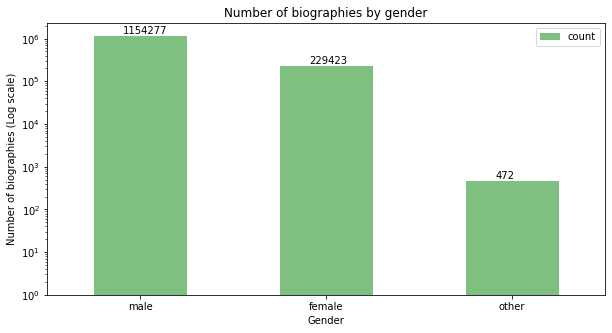

In [8]:
# dataframe to pandas
gender_counts_pd = gender_counts_grouped.toPandas()

pl = gender_counts_pd.plot(kind="bar", x="gender", y="count", figsize=(10, 5), log=True, \
                           alpha=0.5, color="green", rot=0)
for p in pl.patches:
    disp= '{:d}'.format(p.get_height())
    pl.annotate(disp, (p.get_x() + 0.16, p.get_height()*1.1))
    
pl.set_xlabel("Gender")
pl.set_ylabel("Number of biographies (Log scale)")
pl.set_title("Number of biographies by gender");

**Attention**: The y-axis is in log-scale!

In [9]:
n_total = gender_counts_pd['count'].sum()
n_male = gender_counts_pd[gender_counts_pd['gender'] == 'male']['count'].values[0]
n_female = gender_counts_pd[gender_counts_pd['gender'] == 'female']['count'].values[0]
n_other = n_total - n_male - n_female

print("{:.2f}% of the entries are male".format(n_male/n_total*100))
print("{:.2f}% of the entries are female".format(n_female/n_total*100))
print("{:.2f}% of the entries are other gender".format(n_other/n_total*100))

83.39% of the entries are male
16.57% of the entries are female
0.03% of the entries are other gender


Based on these numbers, we decide to **drop the other genders** and continue our analysis with only female and male.

## Data exploration

In this section, we are going to explore how women are represented in Wikipedia. First, we will start with some basic statistics like the fraction of entries that correspond to each gender and how this varies along different occupations.

After, we will enter in the core analysis of the project by analysing the language used to present the different people. The idea is to focus on the adjectives used in the overviews and look for a bias between male and female representations. The length of the overview as well as the percentage of adjective in the overviews will be analyzed. 

In [10]:
WIKI_DATA_FULL = os.path.join(LOCAL_PATH, "wikipedia_male_female.json")
df_full = spark.read.json(WIKI_DATA_FULL)

In [11]:
# Create function to translate a code into a category
def translate(mapping):
    def translate_(col):
        return mapping.get(col)
    return udf(translate_, StringType())

In [12]:
# Translate gender and occupations codes into corresponding labels
df_full = df_full.withColumn('gender', translate(dict_genders)('gender'))

# drop column 'wiki-title' to ease visualization 
df_full_viz = df_full.drop('wiki-title')
df_full_viz.show(5)

+------+---------+--------------------+--------------------+--------------------+
|gender|       id|                name|          occupation|            overview|
+------+---------+--------------------+--------------------+--------------------+
|  male|Q26998233|       A. E. Pickard|                  []|Albert Ernest Pic...|
|  male| Q4647941|       A. J. Masters|['Q177220', 'Q753...|Arthur John Masar...|
|  male| Q4648064|A. L. A. Himmelwr...|['Q13582652', 'Q8...|Abraham Lincoln A...|
|  male| Q4647256|  A. N. Sattampillai|        ['Q1234713']|Arumai Nayakam Sa...|
|  male|   Q84136|         A. Vellayan|          ['Q43845']|A. Vellayan (born...|
+------+---------+--------------------+--------------------+--------------------+
only showing top 5 rows



### Gender distribution

We explore again the gender distribution, once we have dropped the other genders and we see that the dataset is very unbalanced, i.e. more than 80% of the entries are male.

In [13]:
# Query to know how many males and females are in the data frame
df_full.registerTempTable("df_full")

query = """
SELECT gender, count(DISTINCT id) as count
FROM df_full
GROUP BY gender
ORDER BY count DESC
"""

gender_counts = spark.sql(query)
gender_counts = gender_counts.toPandas()

83.39% of the entries are male
16.61% of the entries are female


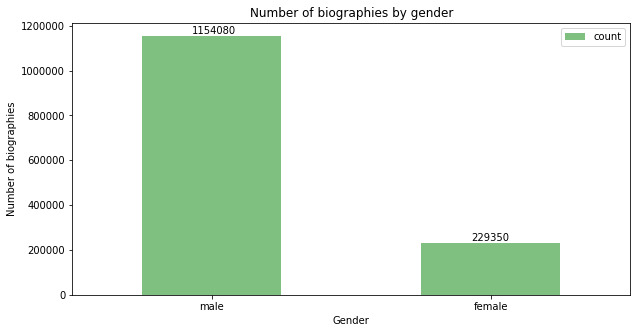

In [14]:
n_total = gender_counts_pd['count'].sum()
n_male = gender_counts_pd[gender_counts_pd['gender'] == 'male']['count'].values[0]
n_female = n_total - n_male

print("{:.2f}% of the entries are male".format(n_male/n_total*100))
print("{:.2f}% of the entries are female".format(n_female/n_total*100))

pl = gender_counts.plot(kind="bar", x="gender", y="count", figsize=(10, 5), log=False, \
                        alpha=0.5, color="green", rot=0)
for p in pl.patches:
    disp= '{:d}'.format(p.get_height())
    pl.annotate(disp, (p.get_x()+0.18, p.get_height()+ 9999))

pl.set_xlabel("Gender")
pl.set_ylabel("Number of biographies")
pl.set_title("Number of biographies by gender");

### Occupation distribution

We explore the most common occupations among biographies and group them into different fields.

In [15]:
df_full = df_full.withColumn('occupation', explode(split(regexp_replace(regexp_replace(regexp_replace\
                                (regexp_replace(df_full['occupation'], '\\[', ''), '\\]', ''), ' ', ''),"'", ""), ",")))\
       .filter(col('occupation') != '')

In [16]:
df_full.registerTempTable("df_full")

query = """
SELECT occupation, count(DISTINCT id) as count
FROM df_full
GROUP BY occupation
ORDER BY count DESC
"""

occu_counts = spark.sql(query)
occu_counts = occu_counts.toPandas()

In [17]:
print("In total there are {} different occupations".format(len(occu_counts)))

In total there are 5891 different occupations


**How do we deal with them?**

In [18]:
n_total = occu_counts['count'].sum()
n_first_100 = occu_counts.iloc[:100]['count'].sum()

print("The 100 most common occupations represent {:.2f}% of the all the biographies".format(n_first_100/n_total*100))

The 100 most common occupations represent 78.58% of the all the biographies


In [19]:
n_101 = occu_counts.iloc[101]['count'].sum()

print("The 101th most common occupation represent {:.2f}% of the all the biographies".format(n_101/n_total*100))

The 101th most common occupation represent 0.16% of the all the biographies


Therefore, we decide to **keep only the first 100 occupations**. The other occupations represent less than 1% of the biographies, so we think they are not worth it to be analyzed in detail.

For the first 100 occupations, we will group them in more general fields (e.g. screenwriter and film director will be grouped into the same category named cinema).

In [20]:
df_full = df_full.withColumn('occupation', translate(dict_occupations)('occupation'))\
            .withColumn('field', translate(dict_cat_occ)('occupation'))

In [21]:
df_full.registerTempTable("df_full")

query = """
SELECT field, count(DISTINCT id) as count
FROM df_full
WHERE field IS NOT NULL
GROUP BY field
ORDER BY count DESC
"""

occu_cat_counts = spark.sql(query)
occu_cat_counts = occu_cat_counts.toPandas()

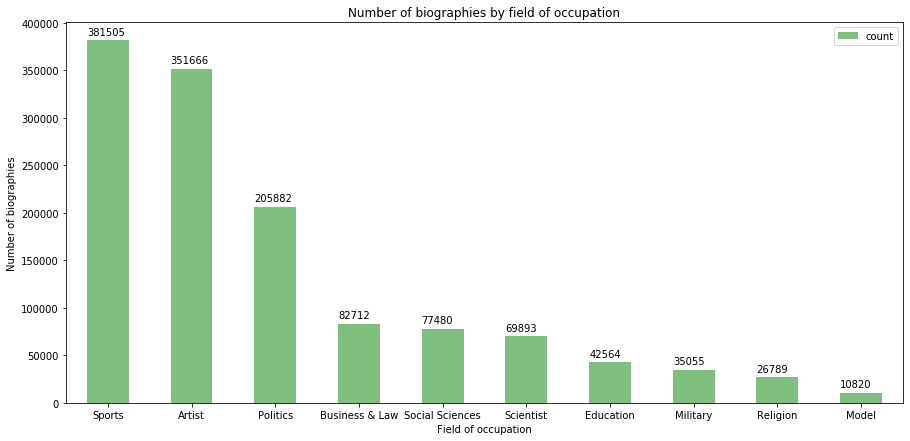

In [22]:
pl = occu_cat_counts.plot(kind="bar", x="field", y="count", figsize=(15, 7), log=False, \
                          alpha=0.5, color="green", rot=0)
for p in pl.patches:
    disp= '{:d}'.format(p.get_height())
    pl.annotate(disp, (p.get_x(), p.get_height()+ 6000))
    
pl.set_xlabel("Field of occupation")
pl.set_ylabel("Number of biographies")
pl.set_title("Number of biographies by field of occupation");

The most common occupation among people in Wikipedia is **Sports** followed by **Artist** and **Politics**. 

In [23]:
n_total = occu_cat_counts['count'].sum()
n_sports = occu_cat_counts[occu_cat_counts['field'] == 'Sports']['count'].values[0]
n_artist = occu_cat_counts[occu_cat_counts['field'] == 'Artist']['count'].values[0]
n_politics = occu_cat_counts[occu_cat_counts['field'] == 'Politics']['count'].values[0]

print("{:.2f}% of the entries work in the sports field".format(n_sports/n_total*100))
print("{:.2f}% of the entries work in the artistic field".format(n_artist/n_total*100))
print("{:.2f}% of the entries work in the politics field".format(n_politics/n_total*100))

29.70% of the entries work in the sports field
27.38% of the entries work in the artistic field
16.03% of the entries work in the politics field


### Gender by occupation

How are the distinct genders represented within the different occupational groups? Is there any group where women have a greater representation than men?

In [24]:
df_full.registerTempTable("df_full")

query = """
SELECT field, gender, count(DISTINCT id) as count
FROM df_full
WHERE field IS NOT NULL
GROUP BY field, gender
ORDER BY field, gender
"""

occu_gender_counts = spark.sql(query)
occu_gender_counts = occu_gender_counts.toPandas()

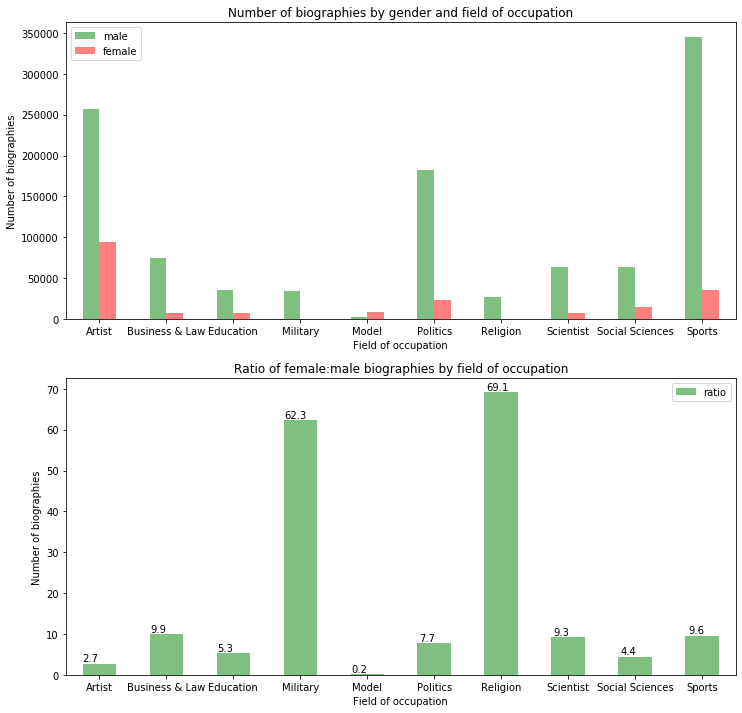

In [25]:
# plot for occupations by gender

male_count = occu_gender_counts[occu_gender_counts['gender'] == 'male']['count'].tolist()
female_count = occu_gender_counts[occu_gender_counts['gender'] == 'female']['count'].tolist()
index = occu_gender_counts['field'].unique().tolist()
occ_by_gender = pd.DataFrame({'male': male_count, 'female': female_count}, index=index)

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
pl = occ_by_gender.plot(kind="bar", log=False, alpha=0.5, color=["green", "red"], rot=0, ax=ax[0])
pl.set_xlabel("Field of occupation")
pl.set_ylabel("Number of biographies")
pl.set_title("Number of biographies by gender and field of occupation");
             
occ_by_gender['ratio'] = occ_by_gender.apply(lambda x: x.male / x.female, axis=1)

pl = occ_by_gender.plot(kind="bar", y='ratio', alpha=0.5, color='green', rot=0, ax=ax[1])
for p in ax[1].patches:
    disp= '{:.1f}'.format(p.get_height())
    ax[1].annotate(disp, (p.get_x() * 1.005, p.get_height() +0.5))
pl.set_xlabel("Field of occupation")
pl.set_ylabel("Number of biographies")
pl.set_title("Ratio of female:male biographies by field of occupation");

From the plot we can point out different details: 
- Female biographies are less in all fields except **Model** which is associated to the mode industry. In this case, for each 5 biographies related to female characters we have one male biography.
- **Religion** and **Military** are the groups where the ratio female:male becomes larger. In religion related biographies for each female we will find 69 males. In military related ones, for each female we will find 62 males.
- The most balanced occupational field is **Artist** where the ratio female:male is of 1:3"
   

### Distribution of the overview's length 
There are very different biographies in the data set, some correspond to Artists, some other to Politicians. The overview's length differs significantly from biography to biography. The largest overview's length is of 23,728 words (without punctuation). The shortest overview's length is of 1. On the following plot we can observe the overview's length distribution. It seems to be a power law distribution with a higher mean than median. 

In [26]:
df = spark.read.json(WIKI_DATA_FULL)

# Remove puncutation from the feature overview
df_overview_len = df.withColumn('overview', regexp_replace(regexp_replace(df['overview'],r'[^\w\s]',''), '\s\s+', ' '))

# Tokenize feature overview
tokenizer = Tokenizer(inputCol="overview", outputCol="overview_tokens")
df_overview_len = tokenizer.transform(df_overview_len)

# Compute length (number of words) of an overview
tokens_len = udf(lambda s: len(s), IntegerType())
df_overview_len = df_overview_len.withColumn('overview_len', tokens_len(df_overview_len['overview']))

In [27]:
# Query to convert a spark data frame into a pandas data frame, 
# the data frame contains the variables id and overview_len
df_overview_len.registerTempTable("df_overview_len")
query = """
SELECT DISTINCT id, overview_len
FROM df_overview_len
WHERE overview_len>0
ORDER BY overview_len
"""

overview_len = spark.sql(query)
overview_len = overview_len.toPandas()

The distribution's minimum is 1.00
The distribution's maximum is 23728.00
The distribution's mean    is 472.99
The distribution's median  is 291.00


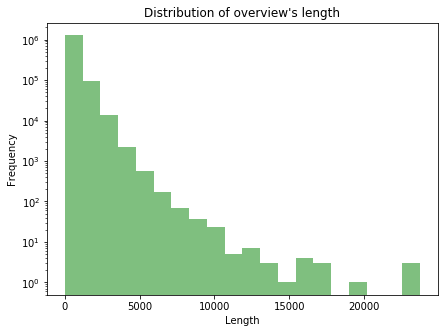

In [28]:
# Print basic statistics
print("The distribution's minimum is {0:.2f}".format(np.min(overview_len['overview_len'])))
print("The distribution's maximum is {0:.2f}".format(np.max(overview_len['overview_len'])))
print("The distribution's mean    is {0:.2f}".format(np.mean(overview_len['overview_len'])))
print("The distribution's median  is {0:.2f}".format(np.median(overview_len['overview_len'])))

# Plot the distribution of overview's length
pl_male = overview_len['overview_len'].plot(kind="hist", figsize=(7, 5), log=True, alpha=0.5, color=["green"], bins=20)
pl_male.set_title('Distribution of overview\'s length')
pl_male.set_xlabel('Length')
pl_male.set_ylabel('Frequency')
plt.show()

### Distribution of the percentage of adjectives in an overview
The distributions of percentage of adjectives in an overview for Males and Females can be observed below.

In [29]:
# Load data frames that include adjectives in each overview
WIKI_MALE = os.path.join(LOCAL_PATH, "wikipedia_male_adjectives.json")
WIKI_FEM = os.path.join(LOCAL_PATH, "wikipedia_female_adjectives.json")

df_male = spark.read.json(WIKI_MALE)
df_fem = spark.read.json(WIKI_FEM)

In [30]:
# Remove punctuation and compute overview's length, adjective's length, and the percentage of adjectives per overview
df_fem = df_fem.withColumn('overview', regexp_replace(regexp_replace(df_fem['overview'],r'[^\w\s]',''), '\s\s+', ' '))
df_fem = df_fem.withColumn('overview_len', tokens_len(df_fem['overview']))\
               .withColumn('adjective_len', tokens_len(df_fem['adjectives']))
df_fem = df_fem.withColumn('adjective_ratio_overview', df_fem['adjective_len']/df_fem['overview_len'])

# Query to convert a spark data frame into a pandas data frame, the data frame contains the variables id, overview_len, adjective_len, adjective_ratio_overview
# Define query
df_fem.registerTempTable("df_fem")
query = """
SELECT DISTINCT id, overview_len, adjective_len, adjective_ratio_overview 
FROM df_fem
WHERE overview_len>0
ORDER BY adjective_ratio_overview
"""
# Execute query
ratio_adj_overview_fem = spark.sql(query)

# Convert to pandas
ratio_adj_overview_fem = ratio_adj_overview_fem.toPandas()

In [31]:
# Remove punctuation and compute overview's length, adjective's length, and the percentage of adjectives per overview
df_male = df_male.withColumn('overview', regexp_replace(regexp_replace(df_male['overview'],r'[^\w\s]',''), '\s\s+', ' '))
df_male = df_male.withColumn('overview_len', tokens_len(df_male['overview']))\
               .withColumn('adjective_len', tokens_len(df_male['adjectives']))
df_male = df_male.withColumn('adjective_ratio_overview', df_male['adjective_len']/df_male['overview_len'])

# Query to convert a spark data frame into a pandas data frame, the data frame contains the variables id, overview_len, adjective_len, adjective_ratio_overview
# Define query
df_male.registerTempTable("df_male")
query = """
SELECT DISTINCT id, overview_len, adjective_len, adjective_ratio_overview 
FROM df_male
WHERE overview_len>0
ORDER BY adjective_ratio_overview
"""
# Execute query
ratio_adj_overview_male = spark.sql(query)
# Convert to pandas
ratio_adj_overview_male = ratio_adj_overview_male.toPandas()

Overall, each overview does not present a large percentage of adjectives. The distribution for the Female gender is a power law. 

DISTRIBUTION FOR FEMALE OVERVIEWS:
The distribution's minimum is 0.02%
The distribution's maximum is 6.67%
The distribution's mean    is 0.35%
The distribution's median  is 0.29%

DISTRIBUTION FOR MALE OVERVIEWS:
The distribution's minimum is 0.02%
The distribution's maximum is 6.67%
The distribution's mean    is 0.35%
The distribution's median  is 0.29%


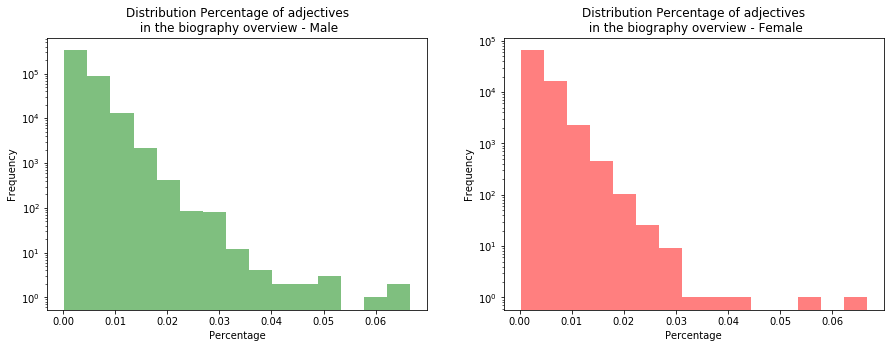

In [32]:
# Print basic statistics
print("DISTRIBUTION FOR FEMALE OVERVIEWS:")
print("The distribution's minimum is {0:.2f}%".format(np.min(ratio_adj_overview_fem['adjective_ratio_overview']*100)))
print("The distribution's maximum is {0:.2f}%".format(np.max(ratio_adj_overview_fem['adjective_ratio_overview']*100)))
print("The distribution's mean    is {0:.2f}%".format(np.mean(ratio_adj_overview_fem['adjective_ratio_overview']*100)))
print("The distribution's median  is {0:.2f}%".format(np.median(ratio_adj_overview_fem['adjective_ratio_overview']*100)))

print("\nDISTRIBUTION FOR MALE OVERVIEWS:")
print("The distribution's minimum is {0:.2f}%".format(np.min(ratio_adj_overview_male['adjective_ratio_overview']*100)))
print("The distribution's maximum is {0:.2f}%".format(np.max(ratio_adj_overview_male['adjective_ratio_overview']*100)))
print("The distribution's mean    is {0:.2f}%".format(np.mean(ratio_adj_overview_male['adjective_ratio_overview']*100)))
print("The distribution's median  is {0:.2f}%".format(np.median(ratio_adj_overview_male['adjective_ratio_overview']*100)))

# Plot the histogram of the feature
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].hist(ratio_adj_overview_male['adjective_ratio_overview'], bins = 15, color = 'green', alpha=0.5)
ax[1].hist(ratio_adj_overview_fem['adjective_ratio_overview'], bins = 15, color = 'red', alpha=0.5)

# Tunning the plot
# Setting title, x and y labels
ax[0].set_title('Distribution Percentage of adjectives\n in the biography overview - Male')
ax[0].set_xlabel('Percentage')
ax[0].set_ylabel('Frequency')
ax[1].set_title('Distribution Percentage of adjectives\n in the biography overview - Female')
ax[1].set_xlabel('Percentage')
ax[1].set_ylabel('Frequency')

ax[0].set_yscale('log')
ax[1].set_yscale('log')

### Number of adjectives in an overview

Once we know the percentage of adjectives per overview, we analyze the number of adjectives that it represents.

In [33]:
# most common adjectives used in male and female overviews
ADJ_MALE = os.path.join(LOCAL_PATH, "count_male_adjectives.json")
ADJ_FEM = os.path.join(LOCAL_PATH, "count_female_adjectives.json")

most_common_adj_male = spark.read.json(ADJ_MALE)
most_common_adj_fem = spark.read.json(ADJ_FEM)

# overviews adjectives for all characters
WIKI_MALE = os.path.join(LOCAL_PATH, "wikipedia_male_nouns_adjectives.json")
WIKI_FEM = os.path.join(LOCAL_PATH, "wikipedia_female_nouns_adjectives.json")

df_male = spark.read.json(WIKI_MALE)
df_fem = spark.read.json(WIKI_FEM)

In [34]:
# get total number of adjectives per overview
def get_nb_adjs(list_adj):
    return len(list_adj)

udf_get_nb_adjs = udf(get_nb_adjs)

df_male_totals = df_male.withColumn("nb-adjs", udf_get_nb_adjs("adjectives"))
df_fem_totals = df_fem.withColumn("nb-adjs", udf_get_nb_adjs("adjectives"))

# compute statistics
def stats_nb_adj(df, gender):
    count_adj = df.agg(mean(col("nb-adjs")), stddev(col("nb-adjs"))).collect()
    print('{}\t| Average num of adjectives: {:.2f} | Std of the num of adjectives: {:.2f}'.\
          format(gender, count_adj[0][0], count_adj[0][1]) )

stats_nb_adj(df_male_totals, 'Male')
stats_nb_adj(df_fem_totals, 'Female')

Male	| Average num of adjectives: 2.13 | Std of the num of adjectives: 1.97
Female	| Average num of adjectives: 1.93 | Std of the num of adjectives: 1.68


## Adjectives analysis

In this section we analyze the adjectives used to describe the different characters. We use the subjectivity lexicon version used in "Theresa Wilson, Janyce Wiebe, and Paul Hoffmann (2005). Recognizing Contextual Polarity in Phrase-Level Sentiment Analysis. Proc. of HLT-EMNLP-2005." [[1]](https://mpqa.cs.pitt.edu/lexicons/subj_lexicon/). This allows to determine the degree of subjectivity of the vocabularity and if the given adjectives are usually employed with a positive or negative connotation. 

First, we will start by associating each adjective with its subjectivity and strength values. We will then visualize the most common adjectives by gender and their associated degree of strength (negative, positive or neutral). Finally, we will study the usage of strongly subjective adjectives based on the gender. 

### Associate subjectivity level and strength to each adjective

In [35]:
# most frequent adjectives for each gender
most_common_adj_male = most_common_adj_male.orderBy(desc("count"))
most_common_adj_fem = most_common_adj_fem.orderBy(desc("count"))

In [36]:
# obtain subjectivity degree and strength of the word
def get_subjectivity(adj):
    return subjectivity_dictionary.get(adj)[1]

def get_strength(adj):
    return subjectivity_dictionary.get(adj)[0]

udf_get_subj = udf(get_subjectivity)
udf_get_strength = udf(get_strength)

most_common_adj_male = most_common_adj_male.withColumn("subjectivity", udf_get_subj("adjectives"))
most_common_adj_fem = most_common_adj_fem.withColumn("subjectivity", udf_get_subj("adjectives"))
most_common_adj_male = most_common_adj_male.withColumn("strength", udf_get_strength("adjectives"))
most_common_adj_fem = most_common_adj_fem.withColumn("strength", udf_get_strength("adjectives"))

In [37]:
# show most common adjectives in each case with their subjectivity and strength
print('\t\t MALE')
most_common_adj_male.show(5)
print('\n\t\t FEMALE')
most_common_adj_fem.show(5)

		 MALE
+----------+-----+------------+----------+
|adjectives|count|subjectivity|  strength|
+----------+-----+------------+----------+
|     right|59358|    positive|strongsubj|
|     large|38046|    positive|  weaksubj|
|   popular|32918|    positive|  weaksubj|
|   notable|29582|    positive|strongsubj|
|      best|28404|    positive|strongsubj|
+----------+-----+------------+----------+
only showing top 5 rows


		 FEMALE
+----------+-----+------------+----------+
|adjectives|count|subjectivity|  strength|
+----------+-----+------------+----------+
|   popular| 8720|    positive|  weaksubj|
|      best| 8010|    positive|strongsubj|
|   notable| 5832|    positive|strongsubj|
|     large| 5139|    positive|  weaksubj|
|      high| 4924|     neutral|  weaksubj|
+----------+-----+------------+----------+
only showing top 5 rows



Up to now we have obtained the most used adjectives for each gender and associate them with their degree of strength and subjectivity. If we compare the top-five adjectives of each gender, we can see there are 3 shared words: **popular**, **best** and **notable**. 

### Word cloud for the most common adjectives

Visualization of the most common adjectives used in the overviews.

In [38]:
adj_male_dict = most_common_adj_male.select('adjectives', 'count').toPandas().set_index('adjectives').T.to_dict('records')
adj_female_dict = most_common_adj_fem.select('adjectives', 'count').toPandas().set_index('adjectives').T.to_dict('records')

In [39]:
# map subjectity of words to colors
word_to_color = dict()

for word in subjectivity_dictionary:
    if subjectivity_dictionary[word][1] == "positive":
        word_to_color[word] = '#377eb8' # blue
    if subjectivity_dictionary[word][1] == "negative":
        word_to_color[word] = '#ff7f00' # orange
    if subjectivity_dictionary[word][1] == "neutral":
        word_to_color[word] = '#999999' # grey

def color_func(word, *args, **kwargs):
    try:
        color = word_to_color[word]
    except KeyError:
        color = '#000000' # black
    return color

In [40]:
def generate_wordcloud(mask_image, adj_dict):
    mask_ = np.array(Image.open(mask_image))
    wc = WordCloud(background_color="white", max_words=500, mask=mask_, 
               contour_width=3, contour_color='peru', color_func=color_func)
    # generate word cloud
    wc.generate_from_frequencies(adj_dict[0])
    
    return wc


def viz_wordcloud(wc_male, wc_fem):
    fig,ax = plt.subplots(1,2, figsize=(20,20))
    ax[0].imshow(wc_male, cmap=plt.cm.gray, interpolation="bilinear")
    ax[0].axis("off")
    ax[1].imshow(wc_fem, cmap=plt.cm.gray, interpolation="bilinear")
    ax[1].axis("off")
    plt.show()

The following word cloud shows the 500 most common adjectives used in male and female biographies. The size of the word is proportional to the frequency of appearance while the color represents the connotation. In <span style="color:#377eb8">**blue**</span>  we see the adjectives ranked as positive, in <span style="color:#ff7f00">**orange**</span>  the ones ranked negative and in <span style="color:#999999">**grey**</span> the ones considered as neutral. 

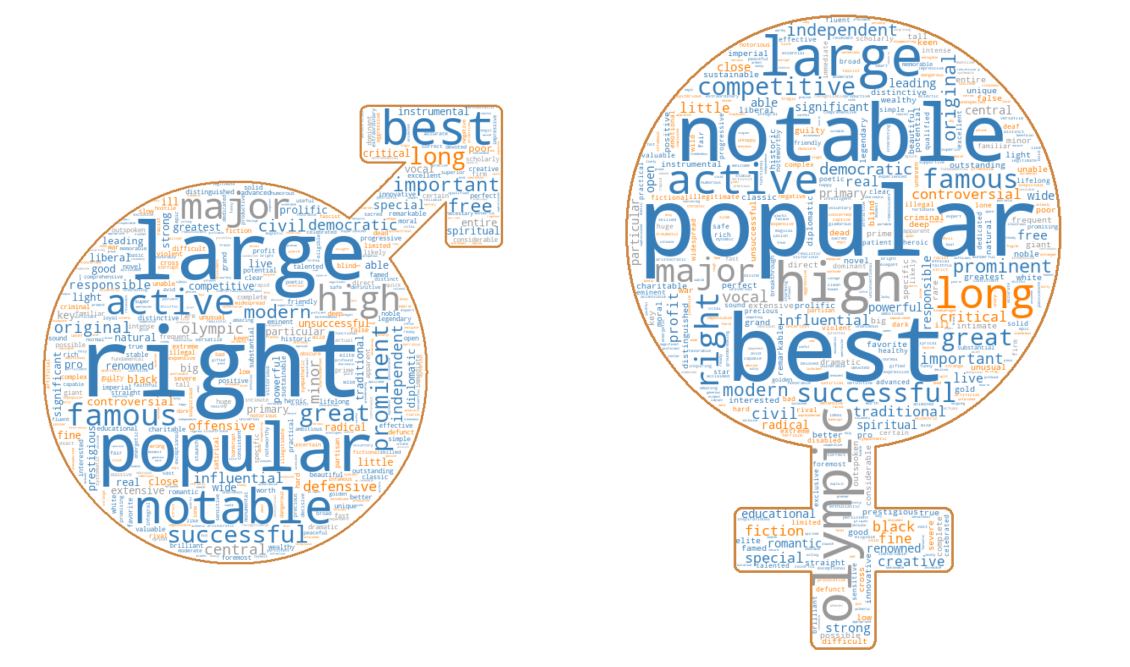

In [41]:
wc_male   = generate_wordcloud("../data/male.png", adj_male_dict)
wc_female = generate_wordcloud("../data/female.png", adj_female_dict)

viz_wordcloud(wc_male, wc_female)

For both genders we see a higher presence of positive-related words as well as some shared adjectives as we showed in the previous subsection. Given the results of this first inspection, we will conduct further quantitative research to see the usage of positive versus negative connoted words and their degree of subjectivity.

### Usage of strongly subjective adjectives depending on the gender

In [42]:
def subjectivity_strength(df):
    """
    compute number of adjectives per strength and subjectivity used in the overviews
    """
    # count adj per strength and subjectivity
    overview_subjectivity = df.groupBy('strength', 'subjectivity').\
    agg(sum('count').alias('sum_')).orderBy(desc('sum_'))
    
    overview_subjectivity = overview_subjectivity.replace('', 'None')
    
    # compute percentage of adj in the strongly subjective category
    strong_adj = df.where((col("strength") == "strongsubj")).\
    groupBy('strength', 'subjectivity').agg({'count':'sum'}).\
    where((col("subjectivity") == "positive") | (col("subjectivity") == "negative"))
    
    strong_adj = strong_adj.\
    withColumn("percentage", 100*strong_adj['sum(count)']/ df.agg({'count':'sum'}).\
               collect()[0][0])

    return overview_subjectivity, strong_adj
    
# compute statistics for each gender
os_male, strength_adj_male = subjectivity_strength(most_common_adj_male)
os_female, strength_adj_female = subjectivity_strength(most_common_adj_fem)

# show results in a single table
os_genders = os_male.withColumnRenamed('sum_', 'male_sum').\
join(os_female.withColumnRenamed('sum_', 'female_sum'), ['strength', 'subjectivity'])

strength_genders = strength_adj_male.withColumnRenamed('percentage', 'male_percentage').\
join(strength_adj_female.withColumnRenamed('percentage', 'female_percentage'), ['strength', 'subjectivity']).\
drop('sum(count)')

# visualize
os_genders_pd = os_genders.toPandas()
strength_genders_pd = strength_genders.toPandas().round(2)

In [43]:
percentage_st = 100*os_genders_pd.groupby('subjectivity').sum()/os_genders_pd[['female_sum','male_sum']].sum()
percentage_st.round(2).rename(columns={'female_sum':'percentage_female', 'male_sum':'percentage_male'})

,percentage_female,percentage_male
subjectivity,,
negative,19.79,20.41
neutral,15.71,15.05
positive,64.51,64.54


In [44]:
percentage_sub = 100*os_genders_pd.groupby('strength').sum()/os_genders_pd[['female_sum','male_sum']].sum()
percentage_sub.round(2).rename(columns={'female_sum':'percentage_female', 'male_sum':'percentage_male'})

,percentage_female,percentage_male
strength,,
strongsubj,31.76,31.43
weaksubj,68.24,68.57


In [45]:
strength_genders_pd

,strength,subjectivity,male_percentage,female_percentage
0,strongsubj,negative,8.64,9.07
1,strongsubj,positive,21.92,21.68


After analysing the distribution of adjectives along the overviews, we can see the distribution of strengths and subjectivities is similar for both genders. In both cases, the usage of negative words to describe the different characters is lower than the positive ones and the adjectives used are mostly weakly subjective.
In terms of strongly subjective words, again the positive ones are more used than the negatives and they are equally distributed for both genders.
Given the analysis about the adjectives conducted up to now, we are still not able to distinguish if there exist a clear linguistic bias in the usage of the words. Nevertheless, the following section will introduce new insights to the discussion.

## Model

### Model using adjectives

In this section, we build a model with the most common adjectives in the overviews of the biographies to find out if there is any bias on how males and females are described. We force to have a balanced dataset and our hypothesis is that if the accuracy obtained is higher than 0.5 there is a bias, because the model is able to learn something from the features. Therefore, if that is the case, we will analyze which adjectives create that bias from the coefficients of the model.

Since the whole dataset is very unbalanced, we take the 100 most common adjectives from male and the 100 most common adjectives from female biographies, and we merge them. That gives us a total of 112 adjectives to use as features of our model. To encode these features, we create a vector of features with 1 if the adjective is present in the overview and 0 if not. The output we want to predict corresponds to the gender of the biographies. We use 0 for male and 1 for female. 

We train a logistic regression model and obtain an accuracy of 58.9% for the test dataset, which means that **the bias exists**. In order to know which adjectives influence more on the linguistic bias, we analyze their coefficients. The higher the coefficient, the more biased to female overviews and the lower the coefficient, the more biased to male overviews. Then, we analyze the subjectivity of these adjecitves.

In [46]:
def most_common(df, num=100):
    """
    get most common adjectives/nouns and return 
    """
    first_100 = df.orderBy(desc("count")).limit(num).toPandas()
    return first_100

def vocabulary_common_adj(most_common_adj_fem, most_common_adj_male):
    # get most common adjectives for male and female
    first_100_adj_male = most_common(most_common_adj_male, 100)
    first_100_adj_fem = most_common(most_common_adj_fem, 100)

    # create vocabulary for the model with the set of adjectives previous found
    most_common_adj = set()
    most_common_adj.update(first_100_adj_male['adjectives'].tolist())
    most_common_adj.update(first_100_adj_fem['adjectives'].tolist())
    most_common_adj = list(most_common_adj)
    print("Total size of vocabulary: {}".format(len(most_common_adj)))
    
    return most_common_adj

In [47]:
# generate df for the model 
def df_model(df):
    df_model = df.withColumn('occupation', explode(split(regexp_replace(regexp_replace(regexp_replace\
                                (regexp_replace(df['occupation'], '\\[', ''), '\\]', ''), ' ', ''),\
                                "'", ""), ","))).filter(col('occupation') != '').withColumn('occupation',\
                                translate(dict_occupations)('occupation')).withColumn('field', \
                                translate(dict_cat_occ)('occupation')).filter(col("field") != '').\
                                withColumn("gender", udf_get_gender("gender"))
    df_model = df_model.select("id", "gender", "adjectives", "nouns", "field").dropDuplicates()
    return df_model
    
df_male_model = df_model(df_male)
df_fem_model = df_model(df_fem)

# convert to pandas
df_male_pd = df_male_model.toPandas()
df_fem_pd = df_fem_model.toPandas()

In [48]:
df_fem_pd

,id,gender,adjectives,nouns,field
0,Q3309194,female,"[amazed, busy, positive, classic, popular, lucky]","[opening, comeback, pop, songs, school, talent...",Artist
1,Q4859424,female,[remarkable],"[model, businesswoman, people, magazines, phot...",Artist
2,Q6780232,female,"[elegant, prominent, refined]","[lectureship, architect, citizen, writer, degr...",Education
3,Q7921455,female,"[best, olympic]","[team, medal, matches, volleyball, player, awa...",Sports
4,Q232963,female,[original],"[singer, finals, delegation, tree, scale, musi...",Artist
...,...,...,...,...,...
71576,Q23712226,female,"[bad, selfish, black, successful, wide, romantic]","[prominence, opportunist, television, screen, ...",Artist
71577,Q3372906,female,[democratic],"[politician, member]",Politics
71578,Q3492899,female,[extensive],"[years, stories, work, books, translation, chi...",Education
71579,Q6205186,female,"[greatest, big]","[hits, candle, albums, album, country, televis...",Artist


In [49]:
# encode input: kind of one-hot coding 🔥
def encode_input(list_words_present, list_adj_to_encode):
    encoding = np.zeros(len(list_adj_to_encode))
    for i, adj in enumerate(list_adj_to_encode):
        if adj in list_words_present:
            encoding[i] = 1
    return encoding

# encode gender
def encode_output(gender):
    return int(gender == 'female')

# apply encoder to df
def encode_df(df, cat, vocabulary):
    df_2 = df.copy()
    df_2['input'] = df_2[cat].map(lambda x: encode_input(x, vocabulary))
    df_2['output'] = df_2.gender.map(lambda x: encode_output(x))
    return df_2

most_common_adj = vocabulary_common_adj(most_common_adj_fem, most_common_adj_male)
    
df_encoded_adj_male = encode_df(df_male_pd, cat='adjectives', vocabulary=most_common_adj)
df_encoded_adj_fem = encode_df(df_fem_pd, cat='adjectives', vocabulary=most_common_adj)

Total size of vocabulary: 112


#### We need to balance the data

In order to do that, we are going to use **propensity score matching**. We are going to use only single feature which is the field of occupation. Therefore, we are going to select the same number of female and male for each field of occupation.

In [50]:
unique_cat_occ = np.unique(list(dict_cat_occ.values()))

In [51]:
def get_input_output_gender(df):
    X = np.stack(df.input)
    y = np.stack(df.output)
    return X,y

def get_input_output(df_fem, df_male):
    X_fem, y_fem = get_input_output_gender(df_fem)
    X_male, y_male = get_input_output_gender(df_male)
    
    X = np.concatenate((X_fem, X_male), axis=0)
    y = np.concatenate((y_fem, y_male), axis=0)
    return X,y

In [52]:
def get_balanced_data(unique_cat_occ, vocabulary, df_fem_pd, df_male_pd):
    # Initialize train and test data
    X_train = np.empty((0,len(vocabulary)))
    X_test = np.empty((0,len(vocabulary)))

    y_train = np.empty((0))
    y_test = np.empty((0))
    
    for cat in unique_cat_occ:
        n_cat_fem = len(df_fem_pd[df_fem_pd['field'] == cat])
        n_cat_male = len(df_male_pd[df_male_pd['field'] == cat])
        n_total = np.min((n_cat_fem, n_cat_male))

        # split data in test and train
        n_train = np.round(0.7 * n_total).astype(np.uint)
        n_test = (n_total - n_train).astype(np.uint)

        # select entries for the train and test df
        if n_cat_fem == n_total:
            train_indices_fem = np.random.choice(range(n_cat_fem), n_train, replace=False)
            test_indices_fem = np.setdiff1d(range(n_cat_fem), train_indices_fem)

            train_indices_male = np.random.choice(range(n_cat_male), n_train, replace=False)
            left_indices_male = np.setdiff1d(range(n_cat_male), train_indices_male)
            test_indices_male = np.random.choice(left_indices_male, n_test, replace=False)

        else: 
            train_indices_male = np.random.choice(range(n_cat_male), n_train, replace=False)
            test_indices_male = np.setdiff1d(range(n_cat_male), train_indices_male)

            train_indices_fem = np.random.choice(range(n_cat_fem), n_train, replace=False)
            left_indices_fem = np.setdiff1d(range(n_cat_fem), train_indices_fem)
            test_indices_fem = np.random.choice(left_indices_fem, n_test, replace=False)

        # ensure balanced dataset
        assert len(train_indices_fem) == len(train_indices_male)
        assert len(test_indices_fem) == len(test_indices_male)

        # build train df
        df_fem_cat_train = df_fem_pd[df_fem_pd['field']==cat].iloc[train_indices_fem]
        df_male_cat_train = df_male_pd[df_male_pd['field']==cat].iloc[train_indices_male]

        # build test df
        df_fem_cat_test = df_fem_pd[df_fem_pd['field']==cat].iloc[test_indices_fem]
        df_male_cat_test = df_male_pd[df_male_pd['field']==cat].iloc[test_indices_male]

        # get input, output from train data
        X_train_cat, y_train_cat = get_input_output(df_fem_cat_train, df_male_cat_train)
        # get input, output from test data
        X_test_cat, y_test_cat = get_input_output(df_fem_cat_test, df_male_cat_test)

        X_train = np.concatenate((X_train, X_train_cat), axis=0)
        y_train = np.concatenate((y_train, y_train_cat), axis=0)

        X_test = np.concatenate((X_test, X_test_cat), axis=0)
        y_test = np.concatenate((y_test, y_test_cat), axis=0)
    return X_train, y_train, X_test, y_test

In [53]:
X_train, y_train, X_test, y_test = get_balanced_data(unique_cat_occ, most_common_adj, df_encoded_adj_fem, df_encoded_adj_male)

In [54]:
print("Number of entries for each gender on train: {}".format(int(y_train.shape[0]/2)))
print("Number of entries for each gender on test: {}".format(int(y_test.shape[0]/2)))

print("\nShape of train input:\t{}".format(X_train.shape))
print("Shape of train output:\t{}".format(y_train.shape))

print("\nShape of test input:\t{}".format(X_test.shape))
print("Shape of test output:\t{}".format(y_test.shape))

Number of entries for each gender on train: 48869
Number of entries for each gender on test: 20944

Shape of train input:	(97738, 112)
Shape of train output:	(97738,)

Shape of test input:	(41888, 112)
Shape of test output:	(41888,)


In [55]:
# generate model
lr = LogisticRegression()

# train the model
lr.fit(X_train, y_train)

# predict
y_pred = lr.predict(X_test)

In [56]:
# confusion matrix (true - rows, pred - cols)
cm = confusion_matrix(y_test, y_pred)

print('Confusion Matrix:\n')
print('T\P \t male \t female')
print('male \t', cm[0,0], '\t', cm[0,1])
print('female \t', cm[1,0], '\t', cm[1,1])
print("\nT - True, P - Predicted")
# accuracy
print("\n\nAccuracy of the model in test dataset: {:.3f}".format(lr.score(X_test, y_test)))
print("AUC ROC of the model in test dataset: {:.3f}".format(roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])))

Confusion Matrix:

T\P 	 male 	 female
male 	 11304 	 9640
female 	 8134 	 12810

T - True, P - Predicted


Accuracy of the model in test dataset: 0.576
AUC ROC of the model in test dataset: 0.613


In [57]:
# Create pandas DataFrame with coefficients and its corresponding adjective
data_pd = {'adjective': most_common_adj, 'coefficient': lr.coef_[0].tolist()}   
df_coef = pd.DataFrame(data_pd) 
df_coef = df_coef.sort_values(by='coefficient', ascending=False).reset_index(drop=True)

In [58]:
# Get subjectivity and strength of the adjectives
df_coef['subjectivity'] = df_coef['adjective'].map(lambda x: get_subjectivity(x))
df_coef['strength'] = df_coef['adjective'].map(lambda x: get_strength(x))

In [59]:
print("Adjectives correlated to female bias:")
df_coef.head(10)

Adjectives correlated to female bias:


,adjective,coefficient,subjectivity,strength
0,competitive,1.057664,positive,weaksubj
1,olympic,1.035020,neutral,weaksubj
2,profit,0.956470,positive,weaksubj
3,cross,0.760167,negative,strongsubj
4,beautiful,0.691355,positive,strongsubj
5,educational,0.530060,positive,weaksubj
6,vocal,0.466604,neutral,weaksubj
7,powerful,0.456234,positive,weaksubj
8,perfect,0.441651,positive,strongsubj
9,positive,0.428544,positive,weaksubj


In [60]:
print("Adjectives correlated to male bias:")
df_coef.tail(10)

Adjectives correlated to male bias:


,adjective,coefficient,subjectivity,strength
102,keen,-0.661925,negative,strongsubj
103,imperial,-0.668129,positive,weaksubj
104,important,-0.745924,positive,weaksubj
105,right,-0.747030,positive,strongsubj
106,unsuccessful,-0.763814,negative,weaksubj
107,fast,-0.771064,neutral,weaksubj
108,diplomatic,-0.789185,positive,weaksubj
109,free,-0.790348,positive,weaksubj
110,offensive,-1.986534,negative,weaksubj
111,defensive,-2.273935,negative,weaksubj


In the results above, we can see the adjectives more biased for both genders. In our next steps, we plan to deeper analyze them.

# Bias per occupation

In [61]:
def filter_occupation(data_df, occupation_field):
    return data_df.filter(col('field') == occupation_field)

In [62]:
def common_adj_df(data_df):
    
    # Create a data frame with the exploded adjectives 
    df_adj_explode_field = data_df.withColumn('adjectives', explode(data_df['adjectives']))

    # Query to compute the most frequent adjectives
    df_adj_explode_field.registerTempTable("df_adj_explode_field")
    query = """
    SELECT DISTINCT adjectives, count(DISTINCT id) as count
    FROM df_adj_explode_field
    GROUP BY adjectives
    ORDER BY count DESC
    """

    # Save Query's results in a spark data frame and in a pandas data frame
    df_adj_field_count = spark.sql(query)
    
    return df_adj_field_count

In [63]:
def vocabulary_most_common_adj(fem_data, male_data):
    
    df_fem_adj_field_count = common_adj_df(fem_data)
    df_male_adj_field_count = common_adj_df(male_data)   
    
    # get most common adjectives for male and female in a certain field
    first_100_adj_male_field = most_common(df_fem_adj_field_count, 100)
    first_100_adj_fem_field = most_common(df_male_adj_field_count, 100)

    # create vocabulary for the model with the set of adjectives previously found
    most_common_adj_field = set()
    most_common_adj_field.update(first_100_adj_male_field['adjectives'].tolist())
    most_common_adj_field.update(first_100_adj_fem_field['adjectives'].tolist())
    most_common_adj_field = list(most_common_adj_field)
    
    return most_common_adj_field

In [64]:
def encode_occupation_input(df_field_model, most_common_adj_field):
    
    # convert both spark data frames previously created to pandas
    df_field_model_pd = df_field_model.toPandas()

    # Kind of one-hot encoding
    df_encoded_adj_field = encode_df(df_field_model_pd, cat='adjectives', vocabulary=most_common_adj_field)
    return df_encoded_adj_field

In [65]:
def train_model_by_occupation(df_encoded_adj_fem_field, df_encoded_adj_male_field, most_common_adj_field, field, verbose=False):

    # Split data into train and test, taking into account the data's balance
    X_train, y_train, X_test, y_test = get_balanced_data(field, most_common_adj_field, df_encoded_adj_fem_field, df_encoded_adj_male_field)

    if verbose: 
        # Print information about the splits
        print("Number of entries for each gender on train: {}".format(int(y_train.shape[0]/2)))
        print("Number of entries for each gender on test: {}".format(int(y_test.shape[0]/2)))

        print("\nShape of train input:\t{}".format(X_train.shape))
        print("Shape of train output:\t{}".format(y_train.shape))

        print("\nShape of test input:\t{}".format(X_test.shape))
        print("Shape of test output:\t{}".format(y_test.shape))
    
    
    # generate model
    lr = LogisticRegression()

    # train the model
    lr.fit(X_train, y_train)

    # predict
    y_pred = lr.predict(X_test)
    
    if verbose:
         # confusion matrix (true - rows, pred - cols)
        cm = confusion_matrix(y_test, y_pred)

        print('Confusion Matrix:\n')
        print('T\P \t male \t female')
        print('male \t', cm[0,0], '\t', cm[0,1])
        print('female \t', cm[1,0], '\t', cm[1,1])
        print("\nT - True, P - Predicted")
        # accuracy
        print("\n\nAccuracy of the model in test dataset: {:.3f}".format(lr.score(X_test, y_test)))
        print("AUC ROC of the model in test dataset: {:.3f}".format(roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])))

    
    # Save accuracy score of the model
    accuracy_score = lr.score(X_test, y_test)
    
    # Save AUC score of the model
    AUC_score = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
    return accuracy_score, AUC_score

In [66]:
n_iter = 50
accuracy_scores_list = []
AUC_scores_list = []

# df_male_model, df_fem_model

for field in list(unique_cat_occ):
    print("Starting iterations for {}".format(field))
    accu_tmp = []
    AUC_tmp = []
    
    # filter the datasets with the occupation field
    df_fem_field = filter_occupation(df_fem_model, field)
    df_male_field = filter_occupation(df_male_model, field)
        
    vocabulary_common_adj = vocabulary_most_common_adj(df_fem_field, df_male_field)
    df_fem_encoded = encode_occupation_input(df_fem_field, vocabulary_common_adj)
    df_male_encoded = encode_occupation_input(df_male_field, vocabulary_common_adj)
    
    # Store in a list a certain field for balancing the data sets
    unique_cat_occ_field = np.array([field], dtype='<U15')
        
    for i in range(n_iter):
        
        acc_scopes = train_model_by_occupation(df_fem_encoded, df_male_encoded, vocabulary_common_adj, unique_cat_occ_field)
        accu_tmp.append(acc_scopes[0])
        AUC_tmp.append(acc_scopes[1])
        
    accuracy_scores_list.append(accu_tmp)
    AUC_scores_list.append(AUC_tmp)

Starting iterations for Artist
Starting iterations for Business & Law
Starting iterations for Education
Starting iterations for Military
Starting iterations for Model
Starting iterations for Politics
Starting iterations for Religion
Starting iterations for Scientist
Starting iterations for Social Sciences
Starting iterations for Sports


In [67]:
bias_occu_accuracy_df = pd.DataFrame(accuracy_scores_list).T
bias_occu_AUC_df = pd.DataFrame(AUC_scores_list).T
bias_occu_accuracy_df.columns = [list(unique_cat_occ)]
bias_occu_AUC_df.columns = [list(unique_cat_occ)]
bias_occu_accuracy_df.to_csv('bias_occu_accuracy_df.csv')
bias_occu_AUC_df.to_csv('bias_occu_AUC_df.csv')

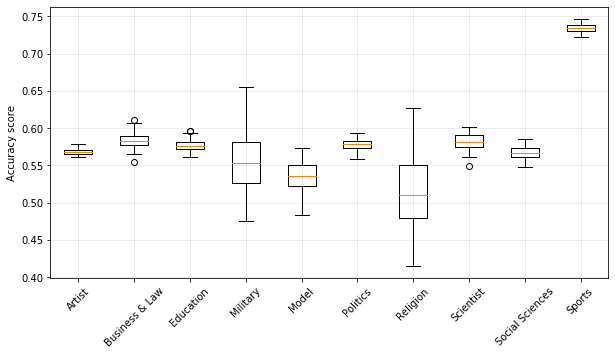

In [68]:
fig, ax = plt.subplots(figsize=(10,5))
pos = np.array(range(bias_occu_accuracy_df.T.shape[0])) + 1
ax.boxplot(bias_occu_accuracy_df.T, positions=pos)
ax.set_xticklabels(unique_cat_occ, rotation = 45)
ax.set_ylabel('Accuracy score')
ax.grid(alpha = 0.3)
plt.show()

In [69]:
bias_occu_accuracy_mean = list(np.mean(bias_occu_accuracy_df))
bias_occu_accuracy_std = list(np.std(bias_occu_accuracy_df))

In [70]:
def print_cv_scores(mean_scores, std_scores, model_names): 
    # Print number of missing values per feature and its corresponding percentage
    dash = '-' * 55
    print(dash)
    print('{:<25s}{:<15s}{:<15s}'.format('Model name','Mean Accuracy', 'Std Accuracy'))
    print(dash)
    for i in range(len(mean_scores)):
        print('{:<25s}{:<15.3f}{:<15.3f}'.format(model_names[i], mean_scores[i], std_scores[i]))
    print(dash)
    
print_cv_scores(bias_occu_accuracy_mean, bias_occu_accuracy_std, list(unique_cat_occ))

-------------------------------------------------------
Model name               Mean Accuracy  Std Accuracy   
-------------------------------------------------------
Artist                   0.568          0.003          
Business & Law           0.584          0.011          
Education                0.577          0.008          
Military                 0.555          0.036          
Model                    0.537          0.020          
Politics                 0.578          0.008          
Religion                 0.515          0.051          
Scientist                0.581          0.011          
Social Sciences          0.568          0.008          
Sports                   0.735          0.006          
-------------------------------------------------------


## Exploring adjectives representation

In [71]:
fem_count = df_fem_model.count()
male_count = df_male_model.count()

fem_adj = df_fem_model.withColumn('adjectives', explode(df_fem_model.adjectives)).\
           groupBy('adjectives').count().toPandas()

male_adj = df_male_model.withColumn('adjectives', explode(df_male_model.adjectives)).\
            groupBy('adjectives').count().toPandas()

adj_presence = fem_adj.merge(male_adj, on='adjectives', suffixes=('_female','_male'))
adj_presence['freq_female'] = 100*adj_presence['count_female']/fem_count
adj_presence['freq_male'] = 100*adj_presence['count_male']/male_count
adj_presence.head()

,adjectives,count_female,count_male,freq_female,freq_male
0,destitute,20,82,0.027940,0.020225
1,inflammatory,4,67,0.005588,0.016525
2,lyrical,114,485,0.159260,0.119621
3,unequivocal,2,3,0.002794,0.000740
4,handicapped,14,68,0.019558,0.016772


#### Adjective appearance in the biographies by gender

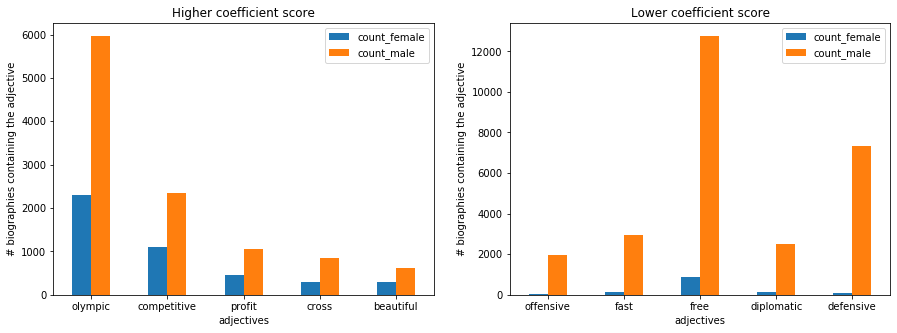

In [72]:
num_adj = 5

f, ax = plt.subplots(1, 2, figsize=(15,5))
adj_presence[adj_presence.adjectives.isin(df_coef.head(num_adj)['adjective'].tolist())][['adjectives', 'count_female', 'count_male']].\
plot(kind='bar', x='adjectives', ax=ax[0], rot=0)
adj_presence[adj_presence.adjectives.isin(df_coef.tail(num_adj)['adjective'].tolist())][['adjectives', 'count_female', 'count_male']].\
plot(kind='bar', x='adjectives', ax=ax[1], rot=0)

ax[0].set_title('Higher coefficient score')
ax[1].set_title('Lower coefficient score')
ax[0].set_ylabel('# biographies containing the adjective')
ax[1].set_ylabel('# biographies containing the adjective')
plt.show()

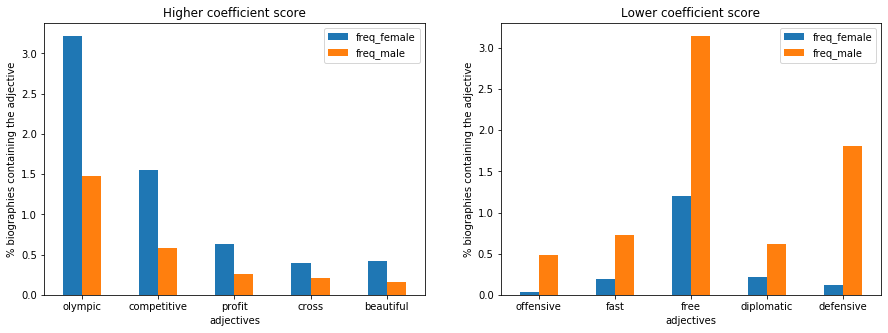

In [73]:
num_adj = 5

f, ax = plt.subplots(1, 2, figsize=(15,5))
adj_presence[adj_presence.adjectives.isin(df_coef.head(num_adj)['adjective'].tolist())][['adjectives', 'freq_female', 'freq_male']].\
plot(kind='bar', x='adjectives', ax=ax[0], rot=0)
adj_presence[adj_presence.adjectives.isin(df_coef.tail(num_adj)['adjective'].tolist())][['adjectives', 'freq_female', 'freq_male']].\
plot(kind='bar', x='adjectives', ax=ax[1], rot=0)

ax[0].set_title('Higher coefficient score')
ax[1].set_title('Lower coefficient score')
ax[0].set_ylabel('% biographies containing the adjective')
ax[1].set_ylabel('% biographies containing the adjective')
plt.show()

### Joint appearance of adjectives

In [74]:
def similarity_score_adj(df_f, df_m, words):
    f_similarity = {}
    m_similarity = {}
    
    fem_common_adj = df_f.withColumn('adjectives', explode(df_f.adjectives))
    male_common_adj = df_m.withColumn('adjectives', explode(df_m.adjectives))
    
    for i in range(len(words)): 
        print("\r Processing {} out of {}".format(i+1, len(words)), end="")
        w1 = words[i]
        f_w1 = set(fem_common_adj[fem_common_adj.adjectives == w1].select('id').dropDuplicates().collect())
        m_w1 = set(male_common_adj[male_common_adj.adjectives == w1].select('id').dropDuplicates().collect())
        
        for j in range(i+1, len(words)):
            w2 = words[j]
            f_w2 = set(fem_common_adj[fem_common_adj.adjectives == w2].select('id').dropDuplicates().collect())
            m_w2 = set(male_common_adj[male_common_adj.adjectives == w2].select('id').dropDuplicates().collect())
        
            f_similarity[(w1, w2)] = len(f_w1.intersection(f_w2))/len(f_w1.union(f_w2))
            f_similarity[(w2, w1)] = f_similarity[(w1, w2)]
            
            m_similarity[(w1, w2)] = len(m_w1.intersection(m_w2))/len(m_w1.union(m_w2))
            m_similarity[(w2, w1)] = m_similarity[(w1, w2)]
    return f_similarity, m_similarity
                

In [75]:
num_adj = 10
fem_sim, male_sim = similarity_score_adj(df_fem_model, df_male_model, \
                    df_coef.head(num_adj)['adjective'].tolist() + df_coef.tail(num_adj)['adjective'].tolist())

 Processing 3 out of 20

KeyboardInterrupt: 

In [ ]:
words = df_coef.head(num_adj)['adjective'].tolist() + df_coef.tail(num_adj)['adjective'].tolist()

f_sim = np.zeros((len(words),len(words)))
m_sim = np.zeros((len(words),len(words)))

for i in range(len(words)):
    for j in range(i+1, len(words)):
        f_sim[i,j] = fem_sim[(words[i], words[j])]
        f_sim[j,i] = f_sim[i,j]
        m_sim[i,j] = male_sim[(words[i], words[j])]
        m_sim[j,i] = m_sim[i,j]

In [ ]:
f, ax = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(f_sim, xticklabels=words, yticklabels=words, cmap='viridis', ax=ax[0])
sns.heatmap(m_sim, xticklabels=words, yticklabels=words, cmap='viridis', ax=ax[1])

ax[0].set_title('Common occurences Females')
ax[1].set_title('Common occurences Males')

plt.show()

### Model using adjectives and nouns

In [76]:
# most common nouns used in male and female overviews
NOUN_MALE = os.path.join(LOCAL_PATH, "count_male_nouns.json")
NOUN_FEM = os.path.join(LOCAL_PATH, "count_female_nouns.json")

most_common_noun_male = spark.read.json(NOUN_MALE)
most_common_noun_fem = spark.read.json(NOUN_FEM)

In [77]:
# get most common nouns for male and female
first_100_noun_male = most_common(most_common_noun_male, 100)
first_100_noun_fem = most_common(most_common_noun_fem, 100)

In [78]:
# get most common adjectives for male and female
first_100_adj_male = most_common(most_common_adj_male, 100)
first_100_adj_fem = most_common(most_common_adj_fem, 100)

In [79]:
# add a column indicating the category (adjective or noun)
first_100_noun_male['cat'] = 'noun'
first_100_noun_fem['cat'] = 'noun'

first_100_adj_male['cat'] = 'adj'
first_100_adj_fem['cat'] = 'adj'

In [80]:
# select columns and rename them
first_100_adj_fem = first_100_adj_fem[['adjectives', 'count', 'cat']]
first_100_adj_fem = first_100_adj_fem.rename(columns={"adjectives": "word"})

first_100_adj_male = first_100_adj_male[['adjectives', 'count', 'cat']]
first_100_adj_male = first_100_adj_male.rename(columns={"adjectives": "word"})

# rename columns
first_100_noun_fem = first_100_noun_male.rename(columns={"nouns": "word"})
first_100_noun_male = first_100_noun_male.rename(columns={"nouns": "word"})

In [81]:
first_adj_noun_fem = first_100_adj_fem.append(first_100_noun_fem).sort_values(by=['count'], ascending=False).\
                        reset_index(drop=True).copy().iloc[:100]
first_adj_noun_male = first_100_adj_male.append(first_100_noun_male).sort_values(by=['count'], ascending=False).\
                        reset_index(drop=True).copy().iloc[:100]

In [82]:
n_adj_fem = np.sum(first_adj_noun_fem['cat'] == 'adj')
n_noun_fem = len(first_adj_noun_fem) - n_adj_fem
print("For female, there are {} adjectives and {} nouns".format(n_adj_fem, n_noun_fem))

n_adj_male = np.sum(first_adj_noun_male['cat'] == 'adj')
n_noun_male = len(first_adj_noun_male) - n_adj_male
print("For male, there are {} adjectives and {} nouns".format(n_adj_male, n_noun_male))

For female, there are 0 adjectives and 100 nouns
For male, there are 8 adjectives and 92 nouns


In [83]:
# create vocabulary for the model with the set of adjectives and nouns previous found
most_common_adj_noun = set()
most_common_adj_noun.update(first_adj_noun_fem['word'].tolist())
most_common_adj_noun.update(first_adj_noun_male['word'].tolist())
most_common_adj_noun = list(most_common_adj_noun)
print("Total size of vocabulary: {}".format(len(most_common_adj_noun)))

Total size of vocabulary: 108


In [84]:
# join nouns and adjectives in a new column called words
df_fem_pd['words'] = df_fem_pd['adjectives'] + df_fem_pd['nouns']
df_male_pd['words'] = df_male_pd['adjectives'] + df_male_pd['nouns']

In [85]:
df_encoded_adj_noun_male = encode_df(df_male_pd, cat='words', vocabulary=most_common_adj_noun)
df_encoded_adj_noun_fem = encode_df(df_fem_pd, cat='words', vocabulary=most_common_adj_noun)

In [86]:
X_train, y_train, X_test, y_test = get_balanced_data(unique_cat_occ, most_common_adj_noun, \
                                                     df_encoded_adj_noun_fem, df_encoded_adj_noun_male)

In [87]:
print("Number of entries for each gender on train: {}".format(int(y_train.shape[0]/2)))
print("Number of entries for each gender on test: {}".format(int(y_test.shape[0]/2)))

print("\nShape of train input:\t{}".format(X_train.shape))
print("Shape of train output:\t{}".format(y_train.shape))

print("\nShape of test input:\t{}".format(X_test.shape))
print("Shape of test output:\t{}".format(y_test.shape))

Number of entries for each gender on train: 48869
Number of entries for each gender on test: 20944

Shape of train input:	(97738, 108)
Shape of train output:	(97738,)

Shape of test input:	(41888, 108)
Shape of test output:	(41888,)


In [88]:
# generate model
lr2 = LogisticRegression()

# train the model
lr2.fit(X_train, y_train)

# predict
y_pred = lr2.predict(X_test)

In [89]:
# confusion matrix (true - rows, pred - cols)
cm = confusion_matrix(y_test, y_pred)

print('Confusion Matrix:\n')
print('T\P \t male \t female')
print('male \t', cm[0,0], '\t', cm[0,1])
print('female \t', cm[1,0], '\t', cm[1,1])
print("\nT - True, P - Predicted")
# accuracy
print("\n\nAccuracy of the model in test dataset: {:.3f}".format(lr2.score(X_test, y_test)))
print("AUC ROC of the model in test dataset: {:.3f}".format(roc_auc_score(y_test, lr2.predict_proba(X_test)[:,1])))

Confusion Matrix:

T\P 	 male 	 female
male 	 13928 	 7016
female 	 7143 	 13801

T - True, P - Predicted


Accuracy of the model in test dataset: 0.662
AUC ROC of the model in test dataset: 0.721


In [90]:
# Create pandas DataFrame with coefficients and its corresponding word
data_pd = {'word': most_common_adj_noun, 'coefficient': lr2.coef_[0].tolist()}   
df_coef_2 = pd.DataFrame(data_pd) 
df_coef_2 = df_coef_2.sort_values(by='coefficient', ascending=False).reset_index(drop=True)

In [91]:
print("Adjectives & Nouns correlated to female bias:")
df_coef_2.head(10)

Adjectives & Nouns correlated to female bias:


,word,coefficient
0,person,1.134785
1,singer,0.840201
2,medal,0.807073
3,spouse,0.772338
4,act*,0.642741
5,event,0.590835
6,team,0.509686
7,children,0.509130
8,election,0.412039
9,best,0.377548


In [92]:
print("Adjectives & Nouns correlated to male bias:")
df_coef_2.tail(15)

Adjectives & Nouns correlated to male bias:


,word,coefficient
93,game,-0.536969
94,war,-0.554739
95,officer,-0.638879
96,seasons,-0.654216
97,midfielder,-0.664362
98,composer,-0.668782
99,men,-0.704960
100,painter,-0.764502
101,musician,-0.898341
102,cricketer,-1.008772


## Analyzing the results using the empath library

We'll analyze the correlated nouns and adjectives

In [93]:
from empath import Empath
lexicon = Empath()

In [94]:
adj_fem = list(df_coef['adjective'].head(50).values)

adj_fem_analyzed = lexicon.analyze(adj_fem, normalize=True)

print("Top topics of the most female correlated adjectives")
sorted(adj_fem_analyzed.items(), key=lambda kv: kv[1], reverse = True)[:10]

Top topics of the most female correlated adjectives


[('wealthy', 0.1),
 ('competing', 0.1),
 ('achievement', 0.08),
 ('attractive', 0.06),
 ('reading', 0.06),
 ('healing', 0.06),
 ('dominant_personality', 0.06),
 ('gain', 0.06),
 ('strength', 0.06),
 ('beauty', 0.06)]

In [95]:
adj_noun_fem = list(df_coef_2['word'].head(50).values)

adj_noun_fem_analyzed = lexicon.analyze(adj_noun_fem, normalize=True)

print("Top topics of the most female correlated adjectives and nouns")
sorted(adj_noun_fem_analyzed.items(), key=lambda kv: kv[1], reverse = True)[:10]

Top topics of the most female correlated adjectives and nouns


[('family', 0.12),
 ('sports', 0.1),
 ('reading', 0.08),
 ('children', 0.08),
 ('college', 0.06),
 ('music', 0.06),
 ('work', 0.06),
 ('youth', 0.06),
 ('wedding', 0.04),
 ('domestic_work', 0.04)]

In [96]:
adj_male = list(df_coef['adjective'].tail(50).values)

adj_male_analyzed = lexicon.analyze(adj_male, normalize=True)

print("Top topics of the most male correlated adjectives")
sorted(adj_male_analyzed.items(), key=lambda kv: kv[1], reverse = True)[:10]

Top topics of the most male correlated adjectives


[('wealthy', 0.06),
 ('stealing', 0.04),
 ('leader', 0.04),
 ('heroic', 0.04),
 ('violence', 0.04),
 ('dominant_heirarchical', 0.04),
 ('fight', 0.04),
 ('war', 0.04),
 ('gain', 0.04),
 ('politics', 0.04)]

In [97]:
adj_noun_male = list(df_coef_2['word'].tail(50).values)

adj_noun_male_analyzed = lexicon.analyze(adj_noun_male, normalize=True)

print("Top topics of the male correlated adjectives and nouns")
sorted(adj_noun_male_analyzed.items(), key=lambda kv: kv[1], reverse = True)[:10]

Top topics of the male correlated adjectives and nouns


[('business', 0.16),
 ('occupation', 0.12),
 ('sports', 0.1),
 ('white_collar_job', 0.1),
 ('school', 0.08),
 ('play', 0.08),
 ('musical', 0.08),
 ('office', 0.06),
 ('dance', 0.06),
 ('art', 0.06)]

## Next steps 

- Validate our results by checking the ratio of the most correlated adjective to a gender (like beautiful for women), to whole dataset (how many female biographies contain that adjective)
- Explore the source of the bias and the parameters that affect it
- Explore biases among occupations 
- Implement the data story

🦄🦄🦄🦄